# 프로젝트: Spectrogram classification 모델 구현

## 데이터 불러오기와 확인

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

print(speech_data.files)

✅
['wav_vals', 'label_vals']


데이터를 읽어왔습니다. 데이터는 wav_vals와 label_vavls로 이루어져있음을 확인 할 수 있었습니다.          
[데이터 주소](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge) 

> 데이터셋의 출처 데이터셋은 캐글의 음성 인식 챌린지의 데이터입니다.               
> Kaggle/TensorFlow Speech Recognition Challenge. 
> This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.



* 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이뤄져 있습니다.
* 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용하겠습니다.
* 모두 1초의 길이를 가지는 오디오 음성데이터이여서 각각 8000개의 sample data를 가지고 있습니다.

위에서 설명한 데이터가 맞는지 확인해봅시다.

In [3]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  21860
Wave data shape :  (8000,)
label :  ['down']



##  데이터 처리와 분류
라벨 데이터 처리하기 sklearn의 train_test_split함수를 이용하여 train, test 분리를 하도록 하겠습니다.

### label 데이터 처리

현재 단어의 정답은 Text 형태로 이뤄져있습니다.          
학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.

아래는 구분해야할 label 목록입니다.

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]

이외 데이터들은 'unknown', 'silence'로 분류되어 있습니다.

In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)



LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']


In [5]:
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하였습니다.           

int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있습니다.



In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

그후 label_val은 np.array형태로 변형하였습니다.

### Spectrogram shape로 변경 
1차원 시계열 데이터인 wav을 단위 시간만큼 Short Time Fourier Transform을 진행해               
매 순간의 주파수 데이터들을 얻어서 2차원인 Spectrogram을 만들 수 있다고 합니다. 

In [7]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


아까 데이터를 확인하기 위해 랜덤을 뽑아봤던 데이터를 spectrogram shape꼴로 변경해 보았습니다.

In [8]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print(spec)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

[[1.8429330e-02 3.7197331e-03 1.9490413e-03 ... 3.7360835e-04
  3.3212323e-02 4.1615181e-02]
 [3.8980812e-02 2.7312102e-02 2.1041345e-02 ... 2.8450983e-02
  2.7965041e-02 1.6765621e-02]
 [6.6360213e-02 4.3084025e-02 1.9389922e-02 ... 3.4865052e-02
  2.1758961e-02 7.4149068e-03]
 ...
 [3.9688027e-03 1.6982337e-03 5.7432678e-04 ... 5.8906263e-04
  2.4970865e-03 4.6569500e-03]
 [3.9115567e-03 2.1149027e-03 8.0342448e-05 ... 1.8724009e-04
  2.6385086e-03 4.9176426e-03]
 [3.9891936e-03 1.9598827e-03 5.0817704e-05 ... 6.3075138e-05
  2.3893286e-03 4.7972938e-03]]
Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


2차원 spectogram으로 변경한 이미지를 출력해겟습니다.           
X축은 시간을 나타내며          
Y축은 주파수를 나타내며                   
해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현된다고 합니다.

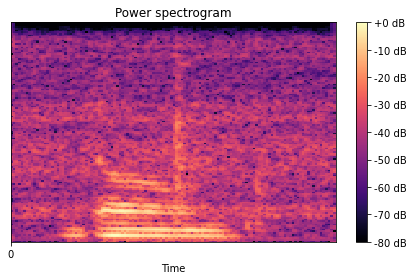

In [9]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

이제 전체 데이터를 변경해 봅니다.

In [10]:
data_spec = []
for wav in speech_data["wav_vals"]:
    stft = wav2spec(wav)
    data_spec.append(stft)
    
    
data_spec = np.array(data_spec)
data_spec.shape

(50620, 130, 126)

In [11]:
print(len(data_spec[8000][129]))
data_spec = np.array(data_spec)
data_spec.shape

126


(50620, 130, 126)

2차원이기때문에 130*126의 형태로 변경된것을 확인 할 수 있었습니다. 이를 np.array꼴로 바꾸어주었습니다. 

In [10]:
del speech_data

데이터 용량이 상당히 크기 때문에 원본 speech_data는 메모리에서 삭제해줍니다. 

###  train, tests 데이터 분리 

In [12]:
from sklearn.model_selection import train_test_split

sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(data_spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)


[[[3.79026658e-03 1.62670575e-03 3.11224954e-04 ... 2.72929698e-04
   1.94097997e-03 3.68709303e-03]
  [3.82094528e-03 2.10952992e-03 3.32605909e-04 ... 1.65451478e-04
   1.78830884e-03 3.68301640e-03]
  [4.32602922e-03 2.09930539e-03 8.39394052e-05 ... 4.26852435e-04
   2.21956172e-03 4.43663634e-03]
  ...
  [1.72882297e-04 5.88753210e-05 2.87630191e-05 ... 3.56727628e-06
   1.18190554e-04 2.30288118e-04]
  [1.73635519e-04 9.54328352e-05 7.68496921e-06 ... 2.70824671e-06
   1.21341385e-04 2.32190025e-04]
  [1.90191757e-04 9.87372478e-05 2.27363626e-06 ... 1.21841231e-06
   1.22425336e-04 2.36706022e-04]]

 [[6.91460818e-03 9.26674227e-04 3.23136635e-02 ... 7.16315291e-04
   1.30159536e-03 2.01713364e-03]
  [1.10484734e-02 1.01269484e-02 3.36611830e-02 ... 2.13010513e-04
   6.70536596e-04 3.05918348e-03]
  [6.30752649e-03 3.53385042e-03 2.52371505e-02 ... 5.90338185e-03
   6.05806569e-03 6.59689587e-03]
  ...
  [5.84675791e-03 2.82478496e-03 1.85044279e-04 ... 1.15364659e-04
   3.66096

In [12]:

train_spec = train_spec.reshape([-1, 130,126, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1,130,126, 1])
print("✅")



✅


train_test_split을 이용하여 train data 와 test data를 분리하였습니다.       
test data는 전체 데이터의 10%를 차지하며, shuffle = True 옵션으로 섞어주었습니다.       
변경한후 CNN을 위해 데이터셋 shape를 변경해주었습니다. 

다시 메모리를 위해 이미 원본 데이터를 삭제해줍니다. 

In [13]:

del data_spec
del label_data

나눠진 데이터셋을 확인해 보겠습니다.

In [14]:


print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)
✅


## Dataset setting
tf.data.Dataset을 이용해서 데이터셋을 구성하도록합니다.          
Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 준다고합니다.




먼저 map 함수에 넘겨줄 데이터 전처리 함수를 작성해 봅니다.

In [16]:
import tensorflow as tf

def one_hot_label(spec,label):
    label = tf.one_hot(label, depth = 12)
    return spec, label



tf.data.Dataset 함수를 구성하겠습니다.           
batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수입니다.

In [17]:
# train

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec,train_label))


tf.data.Dataset.from_tensor_slices 함수에           
return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

In [18]:
train_dataset = train_dataset.map(one_hot_label)



map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 합니다.          
첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.     
map 함수는 중첩해서 사용이 가능합니다.

In [19]:
train_dataset = train_dataset.repeat().batch(batch_size = batch_size)


In [20]:
print(train_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [21]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))


In [22]:
test_dataset = test_dataset.map(one_hot_label)


In [23]:
test_dataset = test_dataset.batch(batch_size = batch_size)

In [24]:
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## model1
모델을 적합합니다. 처음부터 skip이 존재하는 모델을 적합해보겠습니다.          
2차원 data기 때문에 Conv2D를 사용하여 보았습니다. 

In [26]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x,skip_1],-1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x,skip_2],-1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.concat([x,skip_3],-1)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12,activation = 'softmax')(x)

model_spec1 = tf.keras.Model(input_tensor, output_tensor)



loss

In [28]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


model summary

In [29]:
model_spec1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________


### Hyper-parameters setting_1
학습을 위한 하이퍼파라미터를 설정해줍니다.모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.             
후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.           
이번 주제는 모델학습에 오랜 시간이 걸리기때문에 유용할 것 같습니다. 

In [15]:
batch_size = 32
max_epochs = 10



### call back으로 save point 지정_1

In [30]:
# the save point
나눠진 데이터셋을 확인해 보겠습니다.V

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## 모델 학습_1

In [28]:
history_spec1 = model_spec1.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )


print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.9079 - accuracy: 0.7418
Epoch 00001: val_loss improved from inf to 1.75221, saving model to /home/ssac4/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 65s 46ms/step - loss: 1.9079 - accuracy: 0.7418 - val_loss: 1.7522 - val_accuracy: 0.8845
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 1.7178 - accuracy: 0.9183
Epoch 00002: val_loss improved from 1.75221 to 1.69208, saving model to /home/ssac4/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 66s 46ms/step - loss: 1.7178 - accuracy: 0.9183 - val_loss: 1.6921 - val_accuracy: 0.9371
Epoch 3/10
1422/1423 [============================>.] - ETA: 0s - loss: 1.6843 - accuracy: 0.9453
Epoch 00003: val_loss improved from 1.69208 to 1.67547, saving model to /home/ssac4/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 66s 46ms/step 

## model2 non_skip
다음은 skip을 넣지않은 모델을 학습시켜 보겠습니다.

In [25]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12,activation = 'softmax')(x)

model_spec2 = tf.keras.Model(input_tensor, output_tensor)



loss

In [26]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


model summary

In [27]:
model_spec2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 130, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 126, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 130, 126, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 64)        0     


### Hyper-parameters setting_2
학습을 위한 하이퍼파라미터를 설정해줍니다.모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.             
후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.           
이번 주제는 모델학습에 오랜 시간이 걸리기때문에 유용할 것 같습니다. 

In [39]:
batch_size = 32
max_epochs = 10



### call back으로 save point 지정_1

In [28]:
# the save point
checkpoint_dir2 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_nonskip'

cp_callback2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir2,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## 모델학습2

In [29]:
history_spec2 = model_spec2.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback2]
                    )


print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.9227 - accuracy: 0.7324
Epoch 00001: val_loss improved from inf to 1.75807, saving model to /home/ssac4/aiffel/speech_recognition/models/spec_nonskip
1423/1423 [==============================] - 173s 122ms/step - loss: 1.9227 - accuracy: 0.7324 - val_loss: 1.7581 - val_accuracy: 0.8918
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 1.7341 - accuracy: 0.9062
Epoch 00002: val_loss improved from 1.75807 to 1.72141, saving model to /home/ssac4/aiffel/speech_recognition/models/spec_nonskip
1423/1423 [==============================] - 174s 122ms/step - loss: 1.7341 - accuracy: 0.9062 - val_loss: 1.7214 - val_accuracy: 0.9181
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.9427
Epoch 00003: val_loss improved from 1.72141 to 1.69188, saving model to /home/ssac4/aiffel/speech_recognition/models/spec_nonskip
1423/1423 [==============================] - 1

## 학습 결과 plot 

### 모델 1 

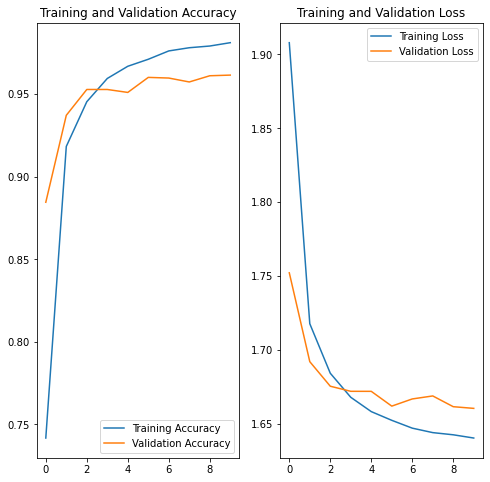

✅


In [29]:
import matplotlib.pyplot as plt

acc = history_spec1.history['accuracy']
val_acc = history_spec1.history['val_accuracy']

loss=history_spec1.history['loss']
val_loss=history_spec1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

val acc가 0.95정도에서 수렴하는것을 확인 할 수 있었다. 

## 학습결과 plot
### 모델 2 

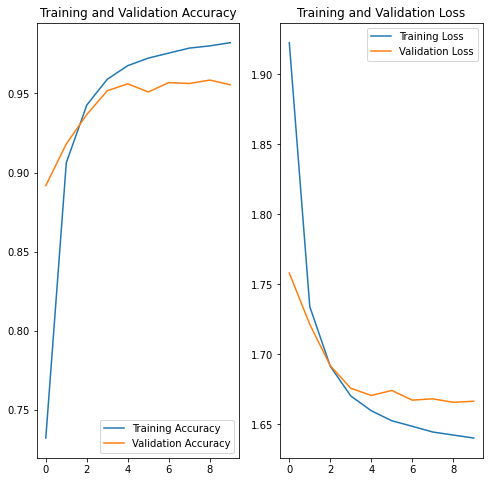

✅


In [30]:
import matplotlib.pyplot as plt

acc = history_spec2.history['accuracy']
val_acc = history_spec2.history['val_accuracy']

loss=history_spec2.history['loss']
val_loss=history_spec2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

model 1과 유사한 결과를 얻었다.         
val_acc는 조금 더 낮고 val loss는 조금더 높은 현상을 보이고 있다. 

## 모델 평가 

test dataset을 통해서 모델을 평가해보도록 한다. 

### load model weight 
checkpoint callback에서 저장한 weight 불러온다. 

In [31]:
model_spec1.load_weights(checkpoint_dir)
print("✅")


✅


In [31]:
model_spec2.load_weights(checkpoint_dir2)
print("✅")

✅


### test데이터를 통한 evaluate 
test_dataset을 통해 모델의 정확도를 평가한다. 

In [32]:
results = model_spec1.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 25s 160ms/step - loss: 1.6411 - accuracy: 0.9806
✅


In [32]:
results2 = model_spec2.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 33s 209ms/step - loss: 1.6657 - accuracy: 0.9585
✅


In [33]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 1.660
accuracy value: 96.1478%
✅


In [33]:
# loss
print("loss value: {:.3f}".format(results2[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results2[1]*100))
print("✅")

loss value: 1.666
accuracy value: 95.8514%
✅


skip을 사용한 model1이 더 좋은 성능을 가진 것을 확인 할 수 있었다. 